In [ ]:
%matplotlib inline

# Eye Tracking Example

This example demonstrates Akida's eye tracking capabilities using the Brainchip's spatiotemporal architecture.

### 1. Import model

The model used for this demonstration can be found at the [Akida 2.0 Model Zoo](https://doc.brainchipinc.com/model_zoo_performance.html#eye-tracking). It has been pre-downloaded and converted to Akida here for efficiency.

In [ ]:
from akida import Model

model = Model("models/tenn_spatiotemporal_eye_buffer_i8_w8_a8.fbz")
model.summary()

### 2. Map the model onto the FPGA

For more details on this flow, please see: [Model Hardware Mapping](https://doc.brainchipinc.com/user_guide/akida.html#model-hardware-mapping)

In [ ]:
import akida
from cnn2snn import set_akida_version, AkidaVersion
# Instantiate akida model
with set_akida_version(AkidaVersion.v2):
    devices = akida.devices()
    if len(devices) > 0:
        print(f'Available devices: {[dev.desc for dev in devices]}')
        device = devices[0]
        print(device.version)
        try:
            model.map(device)
            print(f"Mapping to Akida device {device.desc}.")
            mappedDevice = device.version
        except Exception as e:
            print("Model not compatible with FPGA. Running on CPU.")
            mappedDevice = "CPU"
    else:
        print("No Akida devices found, running on CPU.")
        mappedDevice = "CPU"

#### Model Summary After Mapping

In [ ]:
model.summary()

### 3 Run inference on a sample batch of events

Here, sample events from a DVS camera are preprocessed and evaluated through the Akida model. Event coordinates are visualized, including the tracking prediction location.

#### Import Necessary Libraries

This cell imports essential libraries: matplotplib for event visualizations, the Akida libraries for model execution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
import tensorflow as tf

# Akida neural processor imports
from cnn2snn import set_akida_version, AkidaVersion
import akida

# Eye tracking model preprocessing and postprocessing utilities
from akida_models.tenn_spatiotemporal.eye_preprocessing import preprocess_data
from akida_models.tenn_spatiotemporal.eye_losses import process_detector_prediction

####  Load and segment the sample events

In [ ]:
def load_and_segment_npy(file_path, time_window_us=10_000, segment_duration_us=500_000):
   """
   Loads event data from structured .npy file and segments into 500ms windows
   for model processing.
   
   Args:
       file_path (str): Path to event file with 'p', 'x', 'y', 't' fields
       time_window_us (int): Frame time window in microseconds (10ms default)
       segment_duration_us (int): Segment duration in microseconds (500ms default)
   
   Returns:
       tuple: (processed frame tensors list, raw event segments list)
   """
   # Load structured event data
   data = np.load(file_path)

   # Extract and convert event fields to float32
   p = data['p'].astype('float32')  # Polarity
   x = data['x'].astype('float32')  # X coordinate
   y = data['y'].astype('float32')  # Y coordinate
   t = data['t'].astype('float32')  # Timestamp

   # Stack into tensor format (4, N) for processing
   trial = tf.stack([p, x, y, t], axis=0)

   # Get time bounds for segmentation
   t_start = t[0]
   t_end = t[-1]

   frames_list = []
   segment_list = []

   # Process data in 500ms sliding windows
   current_time = t_start
   while current_time + segment_duration_us <= t_end:
       # Find event indices for current time window
       start_idx = np.searchsorted(t, current_time, side='left')
       end_idx = np.searchsorted(t, current_time + segment_duration_us, side='right')

       # Extract event segment for current window
       segment = tf.stack([
           p[start_idx:end_idx],
           x[start_idx:end_idx],
           y[start_idx:end_idx],
           t[start_idx:end_idx]
       ], axis=0)

       # Create dummy center label for preprocessing
       label = tf.convert_to_tensor([[0.5, 0.5, 0]], dtype=tf.float32)

       # Convert event segment to model-compatible frames
       frames, _ = preprocess_data(
           events=segment,
           label=label,
           train_mode=False,
           frames_per_segment=1,
           spatial_downsample=(6, 6),
           time_window=time_window_us
       )

       frames_list.append(frames)
       segment_list.append(segment)
       current_time += segment_duration_us

   print(f"Processed {len(frames_list)} segments of 500ms each.")
   return frames_list, segment_list

# Load and process eye tracking event data
frames_all, segment_all = load_and_segment_npy("datasets/eye_tracking_event_examples.npy")
n_frames = len(frames_all)
N, H, W, n_ch = frames_all[0].shape

print(f"Loaded data with {n_frames} frames, {H}×{W} pixels, {n_ch} channels")

#### Perform eye tracking inference against sample event data

In [ ]:
# Set up color mapping for visualization channels
if n_ch == 2:
   # Two-channel mode: red and blue
   colors = np.array([[255, 0, 0], [0, 0, 255]], dtype=np.uint8)
else:
   # Multi-channel mode: use matplotlib's tab10 color palette
   import matplotlib
   cmap = matplotlib.cm.get_cmap('tab10', n_ch)
   colors = (cmap(range(n_ch))[:, :3] * 255).astype(np.uint8)

# Initialize plot for real-time visualization
fig, ax = plt.subplots(figsize=(6, 6))

frame_number = 0
cross_size = 3  # Size of prediction cross marker

# Process and visualize each frame
for f in frames_all:
   frame_number += 1
   # Start with gray background for visualization
   frame_vis = np.full((H, W, 3), 128, dtype=np.uint8)

   # Ensure frame is numpy array
   f_np = f.numpy() if isinstance(f, tf.Tensor) else f
   frame = f_np[0]

   # Run model prediction and process output
   pred = model.predict(f_np)
   pred = process_detector_prediction(tf.expand_dims(pred, 0))

   # Convert normalized predictions to pixel coordinates
   y_pred_x = pred[:, 1] * W
   y_pred_y = pred[:, 0] * H

   # Extract prediction center point
   cx = int(y_pred_x.numpy().flatten()[0])
   cy = int(y_pred_y.numpy().flatten()[0])

   # Overlay each channel's events and prediction cross
   for ch in range(n_ch):
       # Create mask for active events in this channel
       mask = frame[:, :, ch] > 0

       # Create cross-shaped mask at predicted location
       pred_mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=bool)
       for i in range(-cross_size, cross_size + 1):
           if 0 <= cx + i < frame.shape[0]:
               pred_mask[cx + i, cy] = True
           if 0 <= cy + i < frame.shape[1]:
               pred_mask[cx, cy + i] = True

       # Apply colors: channel events and yellow prediction cross
       frame_vis[mask] = colors[ch]
       frame_vis[pred_mask] = [255, 255, 0]  # Yellow cross
   
   # Update display with current frame
   ax.clear()
   ax.imshow(frame_vis)
   ax.set_title(f'Frame {frame_number}/{n_frames}')
   ax.axis('off')
   
   # Refresh display for animation effect
   clear_output(wait=True)
   display(fig)
   time.sleep(0.01)  # Control playback speed

plt.close(fig)

### 4 Model Statistics

The advantage of running on a FPGA is the ability to accurately calculate performance, power and area metrics for a given model and process node.

Here are example calculations for the CenterNet model that was tested above.

#### Performance

This Akida 6-Node FPGA is running at __25 MHz__. Based on that knowledge, we need to know the frames per second on the FPGA. The `akida.Model.statistics.fps` will return this value.

In [ ]:
akida_fpga_mhz = 25  # MHz
fps = model.statistics.fps
print(f"FPS @ {akida_fpga_mhz} MHz: {fps}")

To estimate frames per second at a different frequency use the calculation:

$$ \frac{\text{estimated\_fps}}{\text{estimated\_mhz}} = \frac{\text{fps}}{\text{akida\_fpga\_mhz}}$$

$$\text{estimated\_fps} = \frac{\text{fps} \times \text{estimated\_mhz}}{\text{akida\_fpga\_mhz}} $$

In [ ]:
estimated_mhz = 400  # Change this to your desired frequency
estimated_fps = (fps * estimated_mhz) / akida_fpga_mhz
print(f"Estimated FPS @ {estimated_mhz} MHz: {estimated_fps}")

#### Power

Estimating power consumption of a model involves understanding the architecture and size of the model (e.g. # parameters, types of layer operations, etc) as well as a target process node (e.g. TSMC 28nm, Global Foundry 22nm, etc) and target chip frequency (e.g. 400 MHz, 1 GHz, etc).

Brainchip's Solution Architects have access to up to date calculations for the Akida 2.0 Register-transfer-level (RTL) and can perform estimates for your particular model. Contact your BrainChip representative when you have a model ready for estimating.

#### Area

Similar to power, estimating the area size required for a chip to run a model involves understanding the architecture and size of the model (e.g. # parameters, types of layer operations, etc) as well as a target process node (e.g. TSMC 28nm, Global Foundry 22nm, etc) and the ability to leverage RTL options such Hardware Partial Reconfiguration.

A model that executes successfully on the FPGA is capable of receiving accurate sizing estimations. BrainChip's Solution Architects can assist with these calculations.

### 5 Release the Akida FPGA device to free it up for further experiments.

Uncomment the code in the cell below and run the cell.

In [ ]:
# import os
# os._exit(00)

(You can also use this button to reset your kernel)

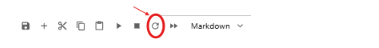